In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")


In [2]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-djiz5imb/unsloth_ac20c9765c4d480f80059fe0667a67d7
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-djiz5imb/unsloth_ac20c9765c4d480f80059fe0667a67d7
  Resolved https://github.com/unslothai/unsloth.git to commit d81b5d7a16b991bfb95eb702e34575eda7b037f1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [4]:
from unsloth import FastVisionModel
import torch


model_id = "google/medgemma-4b-it"


model, tokenizer = FastVisionModel.from_pretrained(
    model_id,
    load_in_4bit=True,
    use_gradient_checkpointing=True,
    )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-11-25 08:12:18.709934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764058338.731180    1295 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764058338.737624    1295 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers was not installed correctly.
Please install xformers separately first.
Then confirm if it's correctly installed by running:
python -m xformers.info

Longer error message:
xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.9.0+cu128 with CUDA 1208 (you have 2.6.0+cu124)
    Python  3.10.19 (you have 3.11.13)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.3: Fast Gemma3 patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.co

In [5]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_layers=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
    target_modules="all-linear"
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [6]:
from datasets import load_dataset

data_dir = "/kaggle/input/my-dataset/dataset/Eczema (EC)"

dataset_dict = load_dataset("imagefolder", data_dir=data_dir, split="train")
dataset_dict

Resolving data files:   0%|          | 0/466 [00:00<?, ?it/s]

Dataset({
    features: ['image'],
    num_rows: 466
})

In [7]:
train_size = 0.8
validation_size = 0.2


from datasets import DatasetDict
data_split = dataset_dict.train_test_split(
    train_size=train_size,
    test_size=validation_size,
    shuffle=True,
    seed=39,
)


val_size = 0.3
test_size = 0.7
temp_split = data_split['test'].train_test_split(
    train_size=test_size,
    test_size=val_size,
    shuffle=True,
    seed=14,
)

data = {
    'train': data_split['train'],
    'validation': temp_split['train'],
    'test': temp_split['test']
}


data = DatasetDict({
    'train': data_split['train'],
    'validation': temp_split['test'],
    'test': temp_split['train'],
})

# Rename the 'test' split to 'validation'
#data["validation"] = data.pop("test")

# Display dataset details
print(data)

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 372
    })
    validation: Dataset({
        features: ['image'],
        num_rows: 29
    })
    test: Dataset({
        features: ['image'],
        num_rows: 65
    })
})


In [8]:
# write a function to create a caption columns 
# This dermatology image shows an eczema, fungal, scabies rash on the a patient skin.

def add_caption(example):
    captions = {
        'Eczema': 'eczema',    #'An image showing skin affected by eczema, characterized by dry, itchy, or inflammed patches.',
        #'fungal': fungal''An image showing a fungal skin infection, often characterized by redness, discoloured areas, and scaling.',
        'Scabies': 'scabies'  #'An image showing a scabies infection on human skin, with red bumps or burror-like marks.'
    }

    label_names = example['label_names']
    label_name = label_names[example['label']]
    
    example['caption'] = captions.get(label_name, 'Image of a skin condition')
    return example



In [9]:
data['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>}

In [10]:
# Check if the dataset has labels
if 'label' in data['train'].features:
    label_names = data['train'].features['label'].names
    dataset = data.map(lambda ex: {**ex, 'label_names':label_names})
    dataset = dataset.map(add_caption)
else:
    # If no labels exist, we need to create a detailed caption
    # Using descriptive caption to help model learn better
    def add_detailed_caption(example):
        example['caption'] = 'This image shows eczema (atopic dermatitis), a common inflammatory skin condition characterized by dry, itchy, and inflamed patches of skin.'
        return example
    
    dataset = data.map(add_detailed_caption)
    print("No labels found in dataset. Using detailed caption about eczema for all images.")

No labels found in dataset. Using detailed caption about eczema for all images.


In [11]:
dataset['train'][0]['caption']

'This image shows eczema (atopic dermatitis), a common inflammatory skin condition characterized by dry, itchy, and inflamed patches of skin.'

In [12]:
dataset['train'][0]['caption']

'This image shows eczema (atopic dermatitis), a common inflammatory skin condition characterized by dry, itchy, and inflamed patches of skin.'

In [13]:
#instruction = "You are an expert dermatolgist, analyze accurately and identify the type of skin condition in the image"


def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            #{"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }

In [14]:
converted_train_dataset = [convert_to_conversation(sample) for sample in dataset['train'].shuffle(seed=22)]
converted_eval_dataset = [convert_to_conversation(sample) for sample in dataset['validation'].shuffle(seed=22)]

In [15]:
converted_train_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'This image shows eczema (atopic dermatitis), a common inflammatory skin condition characterized by dry, itchy, and inflamed patches of skin.'}]}]}

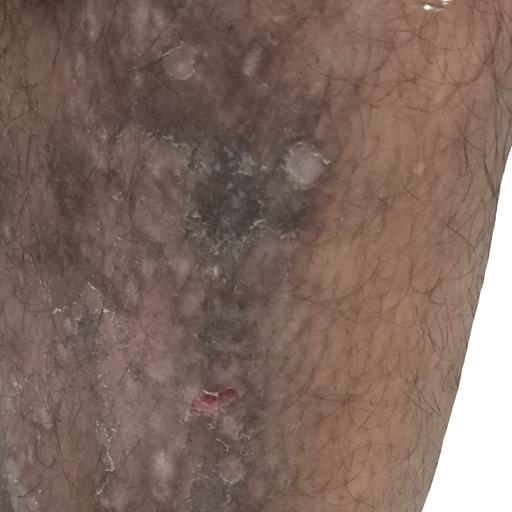

In [16]:
dataset['train'][100]['image']

In [17]:

import torch._dynamo
torch._dynamo.config.suppress_errors = True

FastVisionModel.for_inference(model) # Enable for inference!

image = dataset['train'][100]["image"]
instruction = "You are an expert dermatolgist, analyze accurately and identify the type of skin condition in the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)

# Disable compilation for this specific call
with torch.no_grad():
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    
    # Use torch._dynamo.disable to prevent compilation errors
    with torch._dynamo.config.patch(suppress_errors=True):
        _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                           use_cache = True, temperature = 1.5, min_p = 0.1)

Based on the image, the most likely diagnosis is **Psoriasis**.

Here's why:

*   **Characteristic "Plaque" Lesions:** The image shows well-defined, raised, erythematous (red), and scaly patches that are characteristic of psoriasis.
*   **Distribution:** Psoriasis often presents on extensor surfaces, like the elbows and knees, although it can appear anywhere. The distribution in the image could be consistent with this pattern.
*   **Possible Hyperpigmentation:** The areas of darker pigmentation may be due to post-inflammatory hyperpigmentation or thickening of the skin


In [18]:
# Disable torch compile for older GPUs (P100 has CUDA Capability 6.0, Triton needs >= 7.0)
import torch._dynamo
torch._dynamo.config.suppress_errors = True

FastVisionModel.for_inference(model) # Enable for inference!

image = dataset['train'][15]["image"]
instruction = "You are an expert dermatolgist, analyze accurately and identify the type of skin condition in the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)

# Disable compilation for this specific call
with torch.no_grad():
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    
    # Use torch._dynamo.disable to prevent compilation errors
    with torch._dynamo.config.patch(suppress_errors=True):
        _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                           use_cache = True, temperature = 1.5, min_p = 0.1)

Based on the image, the most likely diagnosis is **Psoriasis**.

Here's why:

*   **Appearance:** The image shows raised, well-defined, slightly scaly plaques with an erythematous (red) base. These are characteristic of psoriasis lesions.

*   **Location:** Psoriasis can appear on the skin of the elbows and knees (as seen in the image).

Important Note:

While the image is suggestive, a definitive diagnosis can only be made by a qualified healthcare professional after a physical examination and, in some cases, a skin biopsy.

**Disclaimer:** I am an AI and


In [19]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig


FastVisionModel.for_training(model)

args = SFTConfig(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        eval_strategy = 'steps',
        save_strategy = 'steps',
        eval_steps = 10,
        save_steps = 10,
        num_train_epochs = 12,
        learning_rate = 1.5e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "cosine_with_restarts",
        seed = 3407,
        output_dir = "medgemma-4b-unsloth-finetuned",
        report_to = "none",
        
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    )

import random
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_train_dataset,
    eval_dataset = converted_eval_dataset,
    args=args
)

Unsloth: Switching to float32 training since model cannot work with float16


In [20]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
5.178 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 372 | Num Epochs = 12 | Total steps = 288
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)


Step,Training Loss,Validation Loss
10,1.641400,1.441604
20,0.277800,0.246556
30,0.002600,0.002669
40,0.004100,0.003952
50,0.002400,0.002249


Unsloth: Not an error, but Gemma3ForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

# Optional: Push to Hugging Face Hub
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

model.push_to_hub("ChristianAgyapong/eczema-medgemma-lora", token=hf_token)
tokenizer.push_to_hub("ChristianAgyapong/eczema-medgemma-lora", token=hf_token)

In [ ]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model",
        load_in_4bit = True,
    )

In [ ]:
if True:
    # Clear memory and reset CUDA to avoid corruption
    import gc
    try:
        del model
        del tokenizer
    except:
        pass
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()  # Wait for all CUDA operations to complete
    
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset['validation'][0]["image"]  # Use first validation image (index 0-28 are valid)
instruction = "You are an expert dermatolgist, analyze accurately and identify the type of skin condition in the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

In [ ]:
dataset

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score


"""model_name = " " # finetune so args.output_dir

model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    laod_in_4bit = True,)"""


model.eval() # evaluation mode

# Get label names - handle single-class datasets
if 'label' in dataset['train'].features:
    label_names = dataset['train'].features["label"].names
else:
    # Single-class dataset (all eczema)
    label_names = ['eczema']
print(f"Label names: {label_names}")



# Batch inference function for single-class datasets
def batch_inference(model, tokenizer, dataset, batch_size=2):
    all_preds = []

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]
        if isinstance(batch, dict):
            for k in batch:
                batch[k] = [batch[k]]
                
        images = batch["image"]

        # Create conversations for each image
        conversations = [
            [
                {"role": "user", "content": [
                    {"type": "image", 'image': img},
                ]}
            ]
            for img in images
        ]

        # Apply chat template
        input_texts = [
            tokenizer.apply_chat_template(conv, add_generation_prompt=True)
            for conv in conversations
        ]

        # Tokenize both text and images
        inputs = tokenizer(
            images,
            input_texts,
            add_special_tokens=False,
            return_tensors="pt",
            padding=True
        ).to("cuda")

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                use_cache=True,
                do_sample=False,  # Greedy decoding for deterministic results
            )

        preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_preds.extend(preds)

    return all_preds

predictions = batch_inference(model, tokenizer, dataset['test'], batch_size=1)

# Count how many predictions contain 'eczema' (case-insensitive)
correct = sum(1 for pred in predictions if 'eczema' in pred.lower())
total = len(predictions)

# Calculate accuracy
accuracy = correct / total
print(f"\nResults:")
print(f"Total test images: {total}")
print(f"Correct predictions: {correct}")
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Let's examine what the model is actually predicting
print("\nSample predictions:")
for i in range(min(10, len(predictions))):
    print(f"\n{i+1}. {predictions[i][:200]}")  # Show first 200 chars of each prediction

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score


"""model_name = " " # finetune so args.output_dir

model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    laod_in_4bit = True,)"""


model.eval() # evaluation mode

# Get label names - handle single-class datasets
if 'label' in dataset['train'].features:
    label_names = dataset['train'].features["label"].names
else:
    # Single-class dataset (all eczema)
    label_names = ['eczema']
print(f"Label names: {label_names}")



# Batch inference function for single-class datasets
def batch_inference(model, tokenizer, dataset, batch_size=2):
    all_preds = []

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]
        if isinstance(batch, dict):
            for k in batch:
                batch[k] = [batch[k]]
                
        images = batch["image"]

        # Create conversations for each image
        conversations = [
            [
                {"role": "user", "content": [
                    {"type": "image", 'image': img},
                ]}
            ]
            for img in images
        ]

        # Apply chat template
        input_texts = [
            tokenizer.apply_chat_template(conv, add_generation_prompt=True)
            for conv in conversations
        ]

        # Tokenize both text and images
        inputs = tokenizer(
            images,
            input_texts,
            add_special_tokens=False,
            return_tensors="pt",
            padding=True
        ).to("cuda")

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,  # Increased to allow full response
                use_cache=True,
                do_sample=False,  # Greedy decoding for deterministic results
            )

        # Decode only the NEW tokens (exclude input)
        input_length = inputs['input_ids'].shape[1]
        generated_ids = outputs[:, input_length:]  # Only new tokens
        preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        all_preds.extend(preds)

    return all_preds

predictions = batch_inference(model, tokenizer, dataset['test'], batch_size=1)

# Count how many predictions contain 'eczema' (case-insensitive)
correct = sum(1 for pred in predictions if 'eczema' in pred.lower())
total = len(predictions)

# Calculate accuracy
accuracy = correct / total
print(f"\nResults:")
print(f"Total test images: {total}")
print(f"Correct predictions: {correct}")
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Let's examine what the model is actually predicting
print("\nSample predictions:")
for i in range(min(10, len(predictions))):
    print(f"\n{i+1}. {predictions[i][:200]}")  # Show first 200 chars of each prediction